In [1]:
# Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

In [2]:
# Functions and classes

class plotting:
    '''
    Class for plotting. 
    '''
    def __init__(self,ax,myxlabel,myylabel,font_sizes,leg):
        self.ax = ax # Axis
        self.myxlabel = myxlabel # x-label
        self.myylabel = myylabel # y-label
        self.font_sizes = font_sizes # font-sizes 
        self.leg = leg # Legend 

    def add_labels(self):
        '''
        Adds labels, grid and optional legend to plot.
        Inputs: 
        ax - plotting object
        myxlabel - xlabel string
        myylabel - ylabel string
        font_sizes - array of size 5 of fontsizes for xlabel string, 
        ylabel string, xticks, yticks and legend
        leg - if 1 put in the legend, otherwise do not
        Output: ax - plotting object with the added inputs
        '''
        self.ax.set_xlabel(self.myxlabel,fontsize=self.font_sizes[0])
        self.ax.set_ylabel(self.myylabel,fontsize=self.font_sizes[1])
        self.ax.grid(color='grey', linestyle='--', linewidth=0.5)
        self.ax.tick_params(axis='x', labelsize=self.font_sizes[2])
        self.ax.tick_params(axis='y', labelsize=self.font_sizes[3])
        if(self.leg==1):
            self.ax.legend(fontsize=self.font_sizes[4])
        return self.ax


def pop_res_model(n,P_0,R_0,dt,a,b,c,d):
    '''
    a: alpha, b: beta, c: gamma, d: delta
    Euler's Method numerical solution.
    NOT USED.
    '''
    P = P_0
    R = R_0
    
    Ps = [P]
    Rs = [R]
    
    for i in range(n-1):
        P = P + dt*(P*(a-b*P/R))
        R = R + dt*(-c*P+d)
    
        Ps.append(P)
        Rs.append(R)
    
    Ps = np.asarray(Ps, float)
    Rs = np.asarray(Rs, float)

    return Ps, Rs

def pop_res_model1(n,P_0,R_0,dt,a,b,c,d):
    '''
    a: alpha, b: beta, c: gamma, d: delta
    Runge-Kutta numerical solution.
    NOT USED.
    '''
    P = P_0
    R = R_0
    
    Ps = [P]
    Rs = [R]
    
    for i in range(n-1):
        k1P, k1R = (P*(a-b*P/R))*dt,dt*(-c*P+d)
        P, R = P+1/2*k1P, R+1/2*k1R
        k2P, k2R = (P*(a-b*P/R))*dt,dt*(-c*P+d)
        P, R = P+1/2*k2P, R+1/2*k2R
        k4P, k4R = (P*(a-b*P/R))*dt,dt*(-c*P+d)
        P, R = P+k4P, R+k4R
        k4P, k4R = (P*(a-b*P/R))*dt,dt*(-c*P+d)
        P = P + 1/6*(k1P+2*k2P+2*k4P+k4P)
        R = R + 1/6*(k1R+2*k2R+2*k4R+k4R)
        Ps.append(P)
        Rs.append(R)
    
    Ps = np.asarray(Ps, float)
    Rs = np.asarray(Rs, float)

    return Ps, Rs

def pop_res_eqns(X_0,t, a, b, c, d):
    '''
    Population resource differential equations
    '''
    P, R = X_0
    Pdot = P*(a - b*P/R)
    Rdot = d - c*P
    Xdot = [Pdot, Rdot]
    return Xdot

def pop_ls_residual(params,P_data,t):
    '''
    Sum of squares of difference in model numerical solution and data
    '''
    P_0 = params[0]
    R_0 = params[1]
    X_0 = [P_0, R_0]
    a = params[2]
    b = params[3]
    c = params[4]
    d = params[5]
    sol = odeint(pop_res_eqns, X_0, t, args=(a,b,c,d))
    P = sol[:, 0]
    ind = np.asarray(np.linspace(0,len(P)-1,len(P_data)),int)
    return np.sum((P_data - P[ind])**2)

def pop_param_fit(params0, bds,P_data,t):
    '''
    Numerical minimum of sum of squares parameter solution of model fitted to data
    '''
    sol=minimize(pop_ls_residual, params0, args=(P_data,t),bounds=bds)
    return sol.x

<Axes: xlabel='Time'>

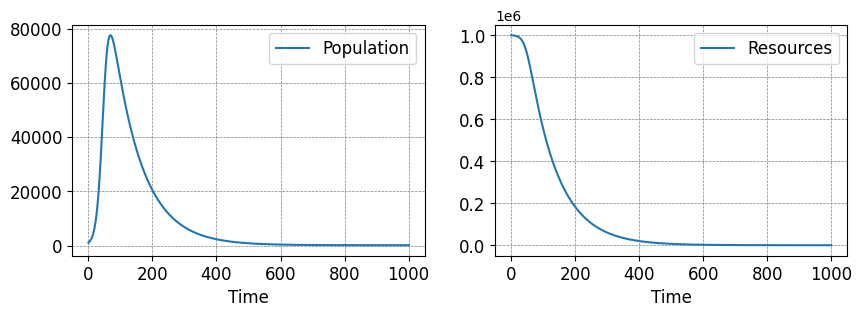

In [29]:
'''
Plot of numerical solution using odeint of population resource model for chosen parameters and initial conditions.

Useful links:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
https://simulationbased.com/2021/02/16/differential-equations-with-scipy-odeint-or-solve_ivp/comment-page-1/
'''

n = 10**5
dt = 10**-2
P_0 = 10**3
R_0 = 10**6
X_0 = [P_0,R_0]
a = 0.1
b = 1
c = 0.1
d = 10
t = np.cumsum(np.ones(n)*dt)
params = (a,b,c,d)

sol = odeint(pop_res_eqns, X_0, t, args=params)
P = sol[:, 0]
R = sol[:, 1]

fig, ax = plt.subplots(1,2,figsize=(10,3)) 

ax[0].plot(t,P, label = 'Population')
ax[1].plot(t,R, label = 'Resources')
leg=1
font_sizes = [12,12,12,12,12]
labels=['Time','',font_sizes,leg]
plotting(ax[0],*labels).add_labels()
plotting(ax[1],*labels).add_labels()

<Axes: xlabel='$P$', ylabel='$R$'>

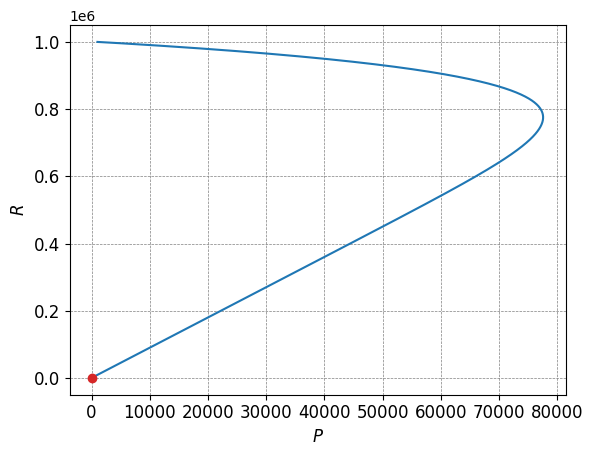

In [30]:
'''
Plot of P vs R with fixed point.
'''
fig, ax = plt.subplots() 

ax.plot(P, R, label = '')
ax.plot(d/c, b*d/a*c,'o',color = 'tab:red')

leg=0
font_sizes = [12,12,12,12,12]
labels=[r'$P$',r'$R$',font_sizes,leg]
plotting(ax,*labels).add_labels()

<Axes: xlabel='Time', ylabel='$P/R$'>

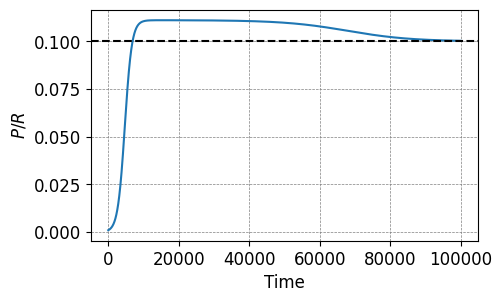

In [26]:
'''
Plot of P divided by R from above along with fixed point.
'''

fig, ax = plt.subplots(figsize=(5,3)) 
ax.plot(P/R)
ax.axhline(a/b,linestyle = '--', color = 'black')

leg = 0
font_sizes = [12,12,12,12,12]
labels=['Time',r'$P/R$',font_sizes,leg]
plotting(ax,*labels).add_labels()

[[100. 100.]]


<Axes: xlabel='$P$', ylabel='$R$'>

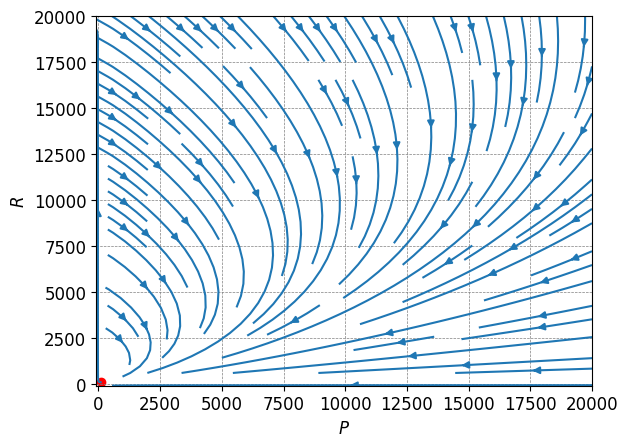

In [27]:
'''
Vector field of dynamical system with chosen parameters.
'''
a = 1
b = 1
c = 1
d = 10**2
fixed_point = np.array([[d/c, b*d/(a*c)]])
print(fixed_point)

l = -1
u = 200
p_l, p_u = l*fixed_point[0][0], u*fixed_point[0][0]
r_l, r_u = l*fixed_point[0][1], u*fixed_point[0][1]

k = 200
p = np.linspace(p_l, p_u, k)
r = np.linspace(r_l, r_u, k)
P, R = np.meshgrid(p, r)

Pdot = P*(a - b*P/R)
Rdot = d - c*P

fig, ax = plt.subplots()
ax.streamplot(P, R, Pdot, Rdot)
ax.scatter(*fixed_point.T, color="r")

leg=0
font_sizes = [12,12,12,12,12]
labels=[r'$P$',r'$R$',font_sizes,leg]
plotting(ax,*labels).add_labels()

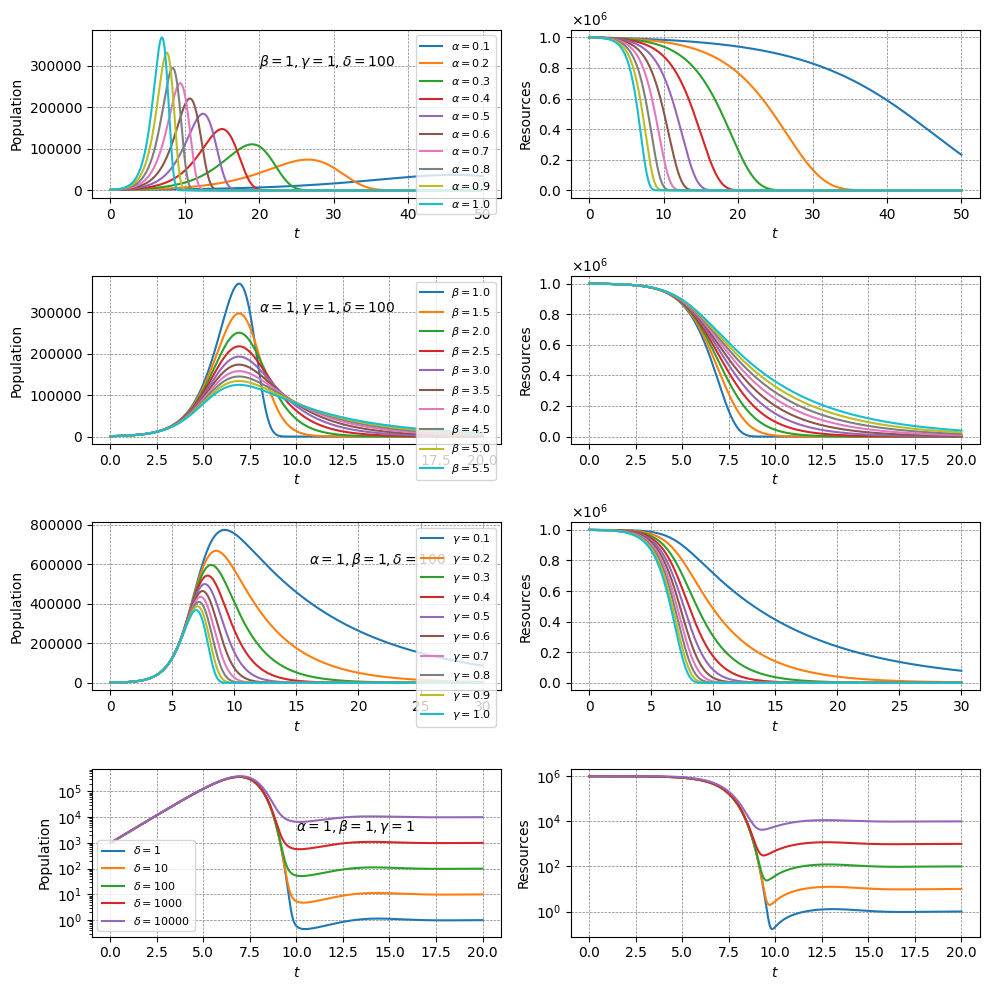

In [28]:
'''
Numerical solutions for population resource model with one parameter changed whilst other three held fixed.
'''

n = 5*10**3
dt = 10**-2
P_0 = 10**3
R_0 = 10**6
X_0 = [P_0,R_0]
t = np.cumsum(np.ones(n)*dt)

params = (0.1,1,1,10**2)

sol = odeint(pop_res_eqns, X_0, t, args=params)

fig, ax = plt.subplots(4,2,figsize=(10,10)) 

a_s = np.arange(0.1,1.1,0.1)
b_s = np.arange(1,6,0.5)
c_s = np.arange(0.1,1.1,0.1)
d_s = [1,10,10**2,10**3,10**4]

a = 1
b = 1
c = 1
d = 10**2

for a_k in a_s:
    params = (a_k,b,c,d)
    sol = odeint(pop_res_eqns, X_0, t, args=params)
    a_k = np.round(a_k,2)
    ax[0,0].plot(t,sol[:, 0], label = r'$\alpha={}$'.format(a_k))
    ax[0,1].plot(t,sol[:, 1], label = r'$\alpha={}$'.format(a_k))
    
ax[0,0].text(20,300000,r'$\beta={}, \gamma={}, \delta={}$'.format(b,c,d), fontsize = 10)

n = 2*10**3
t = np.cumsum(np.ones(n)*dt)
for b_k in b_s:
    params = (a,b_k,c,d)
    sol = odeint(pop_res_eqns, X_0, t, args=params)
    b_k = np.round(b_k,2)
    ax[1,0].plot(t,sol[:, 0], label = r'$\beta={}$'.format(b_k))
    ax[1,1].plot(t,sol[:, 1], label = r'$\beta={}$'.format(b_k))

ax[1,0].text(8,300000,r'$\alpha={}, \gamma={}, \delta={}$'.format(a,c,d), fontsize = 10)

n = 3*10**3
t = np.cumsum(np.ones(n)*dt)
for c_k in c_s:
    params = (a,b,c_k,d)
    sol = odeint(pop_res_eqns, X_0, t, args=params)
    c_k = np.round(c_k,2)
    ax[2,0].plot(t,sol[:, 0], label = r'$\gamma={}$'.format(c_k))
    ax[2,1].plot(t,sol[:, 1], label = r'$\gamma={}$'.format(c_k))

ax[2,0].text(16,600000,r'$\alpha={}, \beta={}, \delta={}$'.format(a,b,d), fontsize = 10)

n = 2*10**3
t = np.cumsum(np.ones(n)*dt)
for d_k in d_s:
    params = (a,b,c,d_k)
    sol = odeint(pop_res_eqns, X_0, t, args=params)
    d_k = int(d_k)
    ax[3,0].plot(t,sol[:, 0], label = r'$\delta={}$'.format(d_k))
    ax[3,1].plot(t,sol[:, 1], label = r'$\delta={}$'.format(d_k))

ax[3,0].text(10,3*10**3,r'$\alpha={}, \beta={}, \gamma={}$'.format(a,b,c), fontsize = 10)

leg=1
leg0 = 0
font_sizes = [10,10,10,10,8]
labels1=[r'$t$','Population',font_sizes,leg]
labels2=[r'$t$','Resources',font_sizes,leg0]
plotting(ax[0,0],*labels1).add_labels()
plotting(ax[0,1],*labels2).add_labels()
plotting(ax[1,0],*labels1).add_labels()
plotting(ax[1,1],*labels2).add_labels()
plotting(ax[2,0],*labels1).add_labels()
plotting(ax[2,1],*labels2).add_labels()
plotting(ax[3,0],*labels1).add_labels()
plotting(ax[3,1],*labels2).add_labels()

ax[0,1].ticklabel_format(style='sci', axis='y', scilimits=(0,0),useMathText=True)
ax[1,1].ticklabel_format(style='sci', axis='y', scilimits=(0,0),useMathText=True)
ax[2,1].ticklabel_format(style='sci', axis='y', scilimits=(0,0),useMathText=True)
ax[3,0].ticklabel_format(style='sci', axis='y', scilimits=(0,0),useMathText=True)
ax[3,1].ticklabel_format(style='sci', axis='y', scilimits=(0,0),useMathText=True)

ax[3,0].set_yscale('log')
ax[3,1].set_yscale('log')

plt.tight_layout()
# plt.savefig('./plots/pop_res_sim.png', bbox_inches='tight')

https://ourworldindata.org/grapher/population

In [8]:
'''
World population data sourced from our world in data:
https://ourworldindata.org/grapher/population
'''
data = pd.read_csv('population.csv')

In [9]:
data1 = data.values
ind = np.where(data1[:,0] == 'World')

In [10]:
dates = data1[:,2][ind]
popn = data1[:,3][ind]

In [12]:
dt = 10**-2

[4.43226600e+06 2.50000000e+10 2.70393534e-02 1.00000000e+00
 1.00000000e+00 4.43226600e+06]
24859872051.07888
[1.32018320e+07 2.48598721e+10 4.92569418e-02 1.00000000e+00
 1.00000000e+00 4.43226600e+06]


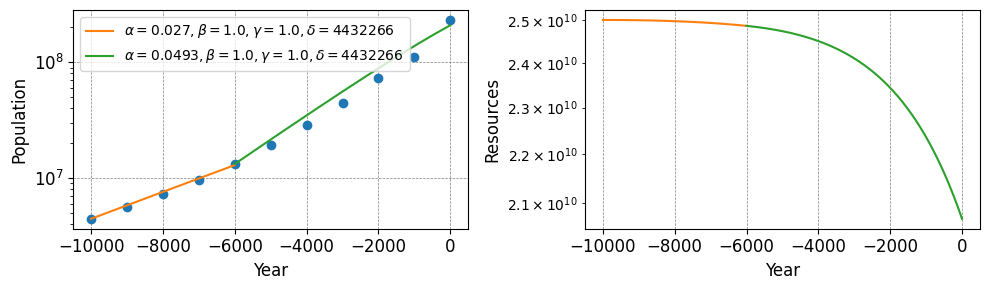

In [13]:
'''
Fits to world population data
'''
k1 = 4
n1 = dates[k1]-dates[0]
dates1 = np.arange(dates[0],dates[k1],1)
P_01 = popn[0]
R_01 = 2.5*10**10
a1 = 0.1
b1 = 1
c1 = 1
d1 = popn[0]
t1 = np.cumsum(np.ones(n1)*dt)
params10 = [P_01,R_01,a1,b1,c1,d1]
bds1 = ((P_01,P_01),(R_01,R_01),(10**(-2),10),(1,1),(1,1),(d1,d1))
P_data1 = popn[:k1+1]
params_pred1 = pop_param_fit(params10, bds1,P_data1,t1)
print(params_pred1)
a1p = params_pred1[2]
b1p = params_pred1[3]
c1p = params_pred1[4]
sol1 = odeint(pop_res_eqns, [P_01, R_01], t1, args=(a1p, b1p, c1p, d1))
P1, R1 = sol1[:, 0], sol1[:, 1]

k2 = k1+6
n2 = dates[k2]-dates[k1]
dates2 = np.arange(dates[k1],dates[k2],1)
P_02 = popn[k1]
R_02 = R1[-1]
print(R_02)
a2 = 0.1
b2 = 1
c2 = 1
d2 = popn[0]
t2 = t1[-1]+np.cumsum(np.ones(n2)*dt)
params20 = [P_02,R_02,a2,b2,c2,d2]
bds2 = ((P_02,P_02),(R_02,R_02),(10**(-2),10**1),(1,1),(1,1),(d2,d2))
P_data2 = popn[k1:k2+1]
params_pred2 = pop_param_fit(params20, bds2,P_data2,t2)
print(params_pred2)
a2p = params_pred2[2]
b2p = params_pred2[3]
c2p = params_pred2[4]
sol2 = odeint(pop_res_eqns, [P_02, R_02], t2, args=(a2p, b2p, c2p, d2))
P2, R2 = sol2[:, 0], sol2[:, 1]


fig, ax = plt.subplots(1,2,figsize=(10,3)) 

ax[0].plot(dates[:k2+1],popn[:k2+1],'o', label = '')
ax[0].plot(dates1,P1, label = r'$\alpha={},\beta={},\gamma={},\delta={}$'.format(np.round(a1p,4),np.round(b1p,4),np.round(c1p,4),d1),
          color = 'tab:orange')
ax[0].plot(dates2,P2, label = r'$\alpha={},\beta={},\gamma={},\delta={}$'.format(np.round(a2p,4),np.round(b2p,4),np.round(c2p,4),d2),
          color = 'tab:green')

ax[1].plot(dates1,R1,color = 'tab:orange')
ax[1].plot(dates2,R2,color = 'tab:green')

leg = 1
leg0 = 0
font_sizes = [12,12,12,12,10]
labels=['Year','Population',font_sizes,leg]
labels1=['Year','Resources',font_sizes,leg0]
plotting(ax[0],*labels).add_labels()
plotting(ax[1],*labels1).add_labels()
ax[0].set_yscale('log')
ax[1].set_yscale('log')

plt.tight_layout()

20693829004.695923
[2.32123764e+08 2.06938290e+10 4.12091462e-02 1.00000000e+00
 1.00000000e+00 4.43226600e+06]


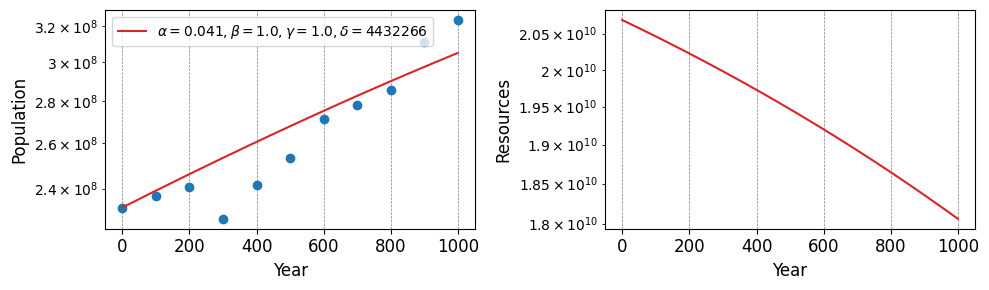

In [14]:
k2 = k2
k3 = k2+10
n3 = dates[k3]-dates[k2]
dates3 = np.arange(dates[k2],dates[k3],1)
P_03 = popn[k2]
R_03 = R2[-1]
print(R_03)
a3 = 0.1
b3 = 1
c3 = 1
d3 = popn[0]
t3 = t2[-1]+np.cumsum(np.ones(n3)*dt)
params30 = [P_03,R_03,a3,b3,c3,d3]
bds3 = ((P_03,P_03),(R_03,R_03),(10**(-2),10**1),(1,1),(1,1),(d3,d3))
P_data3 = popn[k2:k3+1]
params_pred3 = pop_param_fit(params30, bds3,P_data3,t3)
print(params_pred3)
a3p = params_pred3[2]
b3p = params_pred3[3]
c3p = params_pred3[4]
sol3 = odeint(pop_res_eqns, [P_03, R_03], t3, args=(a3p, b3p, c3p, d3))
P3, R3 = sol3[:, 0], sol3[:, 1]

fig, ax = plt.subplots(1,2,figsize=(10,3)) 
ax[0].plot(dates[k2:k3+1],popn[k2:k3+1],'o', label = '')
ax[0].plot(dates3,P3, label = r'$\alpha={},\beta={},\gamma={},\delta={}$'.format(np.round(a3p,3),np.round(b3p,3),np.round(c3p,3),d3)
          ,color = 'tab:red')

ax[1].plot(dates3,R3,color = 'tab:red')

leg = 1
leg0 = 0
font_sizes = [12,12,12,12,10]
labels=['Year','Population',font_sizes,leg]
labels1=['Year','Resources',font_sizes,leg0]
plotting(ax[0],*labels).add_labels()
plotting(ax[1],*labels1).add_labels()
ax[0].set_yscale('log')
ax[1].set_yscale('log')

plt.tight_layout()

18058890300.04439
[3.23407571e+08 1.80588903e+10 1.12449072e-01 1.00000000e+00
 1.00000000e+00 4.43226600e+06]
14960901539.202864
[5.92706212e+08 1.49609015e+10 5.46643564e-01 1.00000000e+00
 1.00000000e+00 4.43226600e+06]
14206664290.406542
[9.85340629e+08 1.42066643e+10 5.75537887e-01 1.00000000e+00
 1.00000000e+00 4.43226600e+06]
13399088665.903538
[1.34169761e+09 1.33990887e+10 8.81889373e-01 1.00000000e+00
 1.00000000e+00 4.43226600e+06]
11954742832.63387
[2.49932211e+09 1.19547428e+10 2.15277070e+00 1.00000000e+00
 1.00000000e+00 4.43226600e+06]


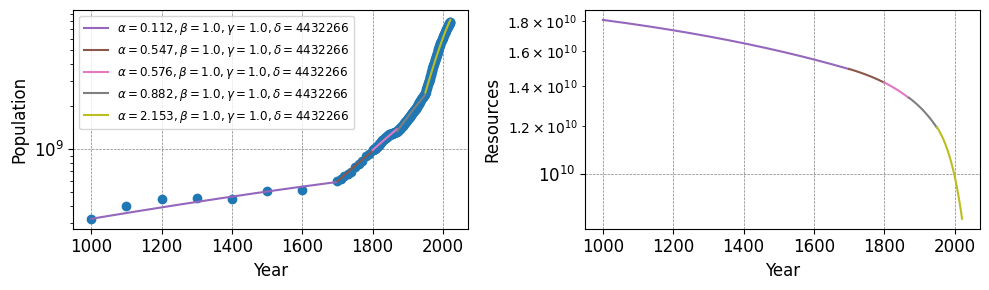

In [15]:
k4 = k3+7
n4 = dates[k4]-dates[k3]
dates4 = np.arange(dates[k3],dates[k4],1)
P_04 = popn[k3]
R_04 = R3[-1]
print(R_04)
a4 = 0.1
b4 = 1
c4 = 1
d4 = popn[0]
t4 = t3[-1]+np.cumsum(np.ones(n4)*dt)
params40 = [P_04,R_04,a4,b4,c4,d4]
bds4 = ((P_04,P_04),(R_04,R_04),(10**(-2),10**1),(1,1),(1,1),(d4,d4))
P_data4 = popn[k3:k4+1]
params_pred4 = pop_param_fit(params40, bds4,P_data4,t4)
print(params_pred4)
a4p = params_pred4[2]
b4p = params_pred4[3]
c4p = params_pred4[4]
sol4 = odeint(pop_res_eqns, [P_04, R_04], t4, args=(a4p, b4p, c4p, d4))
P4, R4 = sol4[:, 0], sol4[:, 1]

k4 = k4
k5 = k4+10
n5 = dates[k5]-dates[k4]
dates5 = np.arange(dates[k4],dates[k5],1)
P_05 = popn[k4]
R_05 = R4[-1]
print(R_05)
a5 = 0.1
b5 = 1
c5 = 1
d5 = popn[0]
t5 = t4[-1]+np.cumsum(np.ones(n5)*dt)
params50 = [P_05,R_05,a5,b5,c5,d5]
bds5 = ((P_05,P_05),(R_05,R_05),(10**(-2),10**1),(1,1),(1,1),(d5,d5))
P_data5 = popn[k4:k5+1]
params_pred5 = pop_param_fit(params50, bds5,P_data5,t5)
print(params_pred5)
a5p = params_pred5[2]
b5p = params_pred5[3]
c5p = params_pred5[4]
sol5 = odeint(pop_res_eqns, [P_05, R_05], t5, args=(a5p, b5p, c5p, d5))
P5, R5 = sol5[:, 0], sol5[:, 1]

k6 = k5+70
n6 = dates[k6]-dates[k5]
dates6 = np.arange(dates[k5],dates[k6],1)
P_06 = popn[k5]
R_06 = R5[-1]
print(R_06)
a6 = 0.1
b6 = 1
c6 = 1
d6 = popn[0]
t6 = t5[-1]+np.cumsum(np.ones(n6)*dt)
params60 = [P_06,R_06,a6,b6,c6,d6]
bds6 = ((P_06,P_06),(R_06,R_06),(10**(-2),10**1),(1,1),(1,1),(d6,d6))
P_data6 = popn[k5:k6+1]
params_pred6 = pop_param_fit(params60, bds6,P_data6,t6)
print(params_pred6)
a6p = params_pred6[2]
b6p = params_pred6[3]
c6p = params_pred6[4]
sol6 = odeint(pop_res_eqns, [P_06, R_06], t6, args=(a6p, b6p, c6p, d6))
P6, R6 = sol6[:, 0], sol6[:, 1]

k7 = k6+80
n7 = dates[k7]-dates[k6]
dates7 = np.arange(dates[k6],dates[k7],1)
P_07 = popn[k6]
R_07 = R6[-1]
print(R_07)
a7 = 0.1
b7 = 1
c7 = 1
d7 = popn[0]
t7 = t6[-1]+np.cumsum(np.ones(n7)*dt)
params70 = [P_07,R_07,a7,b7,c7,d7]
bds7 = ((P_07,P_07),(R_07,R_07),(10**(-2),10**1),(1,1),(1,1),(d7,d7))
P_data7 = popn[k6:k7+1]
params_pred7 = pop_param_fit(params70, bds7,P_data7,t7)
print(params_pred7)
a7p = params_pred7[2]
b7p = params_pred7[3]
c7p = params_pred7[4]
sol7 = odeint(pop_res_eqns, [P_07, R_07], t7, args=(a7p, b7p, c7p, d7))
P7, R7 = sol7[:, 0], sol7[:, 1]

k8 = -1
n8 = dates[k8]-dates[k7]+1
dates8 = np.arange(dates[k7],dates[k8]+1,1)
P_08 = popn[k7]
R_08 = R7[-1]
print(R_08)
a8 = 0.1
b8 = 1
c8 = 1
d8 = popn[0]
t8 = t7[-1]+np.cumsum(np.ones(n8)*dt)
params80 = [P_08,R_08,a8,b8,c8,d8]
bds8 = ((P_08,P_08),(R_08,R_08),(10**(-2),10**1),(1,1),(1,1),(d8,d8))
P_data8 = popn[k7:k8]
params_pred8 = pop_param_fit(params80, bds8,P_data8,t8)
print(params_pred8)
a8p = params_pred8[2]
b8p = params_pred8[3]
c8p = params_pred8[4]
sol8 = odeint(pop_res_eqns, [P_08, R_08], t8, args=(a8p, b8p, c8p, d8))
P8, R8 = sol8[:, 0], sol8[:, 1]

fig, ax = plt.subplots(1,2,figsize=(10,3)) 
ax[0].plot(dates[k3:],popn[k3:],'o', label = '')
ax[0].plot(dates4,P4, label = r'$\alpha={},\beta={},\gamma={},\delta={}$'.format(np.round(a4p,3),np.round(b4p,3),np.round(c4p,3),d4)
          ,color = 'tab:purple')
ax[0].plot(dates5,P5, label = r'$\alpha={},\beta={},\gamma={},\delta={}$'.format(np.round(a5p,3),np.round(b5p,3),np.round(c5p,3),d5)
          ,color = 'tab:brown')
ax[0].plot(dates6,P6, label = r'$\alpha={},\beta={},\gamma={},\delta={}$'.format(np.round(a6p,3),np.round(b6p,3),np.round(c6p,3),d6)
          ,color = 'tab:pink')
ax[0].plot(dates7,P7, label = r'$\alpha={},\beta={},\gamma={},\delta={}$'.format(np.round(a7p,3),np.round(b7p,3),np.round(c7p,3),d7)
          ,color = 'tab:grey')
ax[0].plot(dates8,P8, label = r'$\alpha={},\beta={},\gamma={},\delta={}$'.format(np.round(a8p,3),np.round(b8p,3),np.round(c8p,3),d8)
          ,color = 'tab:olive')

ax[1].plot(dates4,R4,color = 'tab:purple')
ax[1].plot(dates5,R5,color = 'tab:brown')
ax[1].plot(dates6,R6,color = 'tab:pink')
ax[1].plot(dates7,R7,color = 'tab:grey')
ax[1].plot(dates8,R8,color = 'tab:olive')

leg = 1
leg0 = 0
font_sizes = [12,12,12,12,8.6]
labels=['Year','Population',font_sizes,leg]
labels1=['Year','Resources',font_sizes,leg0]
plotting(ax[0],*labels).add_labels()
plotting(ax[1],*labels1).add_labels()
ax[0].set_yscale('log')
ax[1].set_yscale('log')

plt.tight_layout()

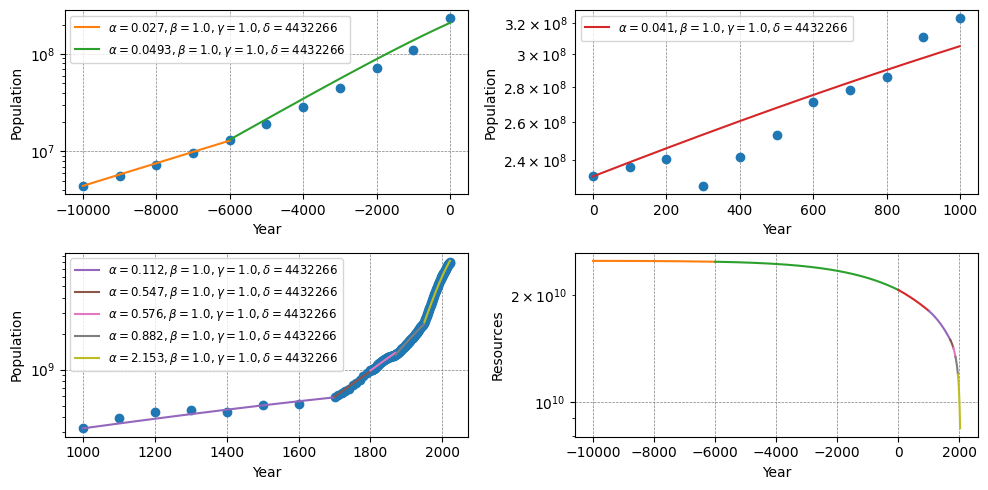

In [16]:
fig, ax = plt.subplots(2,2,figsize=(10,5)) 

ax[0,0].plot(dates[:k2+1],popn[:k2+1],'o', label = '')
ax[0,0].plot(dates1,P1, label = r'$\alpha={},\beta={},\gamma={},\delta={}$'.format(np.round(a1p,4),np.round(b1p,4),np.round(c1p,4),d1),
            color = 'tab:orange')
ax[0,0].plot(dates2,P2, label = r'$\alpha={},\beta={},\gamma={},\delta={}$'.format(np.round(a2p,4),np.round(b2p,4),np.round(c2p,4),d2),
            color = 'tab:green')

leg=1
font_sizes = [10,10,10,10,8.5]
labels=['Year','Population',font_sizes,leg]
plotting(ax[0,0],*labels).add_labels()
ax[0,0].set_yscale('log')

ax[0,1].plot(dates[k2:k3+1],popn[k2:k3+1],'o', label = '')
ax[0,1].plot(dates3,P3, label = r'$\alpha={},\beta={},\gamma={},\delta={}$'.format(np.round(a3p,3),np.round(b3p,3),np.round(c3p,3),d3),
            color = 'tab:red')
leg=1
font_sizes = [10,10,10,10,8.5]
labels=['Year','Population',font_sizes,leg]
plotting(ax[0,1],*labels).add_labels()
ax[0,1].set_yscale('log')

ax[1,0].plot(dates[k3:],popn[k3:],'o', label = '')
ax[1,0].plot(dates4,P4, label = r'$\alpha={},\beta={},\gamma={},\delta={}$'.format(np.round(a4p,3),np.round(b4p,3),np.round(c4p,3),d4),
             color = 'tab:purple')
ax[1,0].plot(dates5,P5, label = r'$\alpha={},\beta={},\gamma={},\delta={}$'.format(np.round(a5p,3),np.round(b5p,3),np.round(c5p,3),d5),
             color = 'tab:brown')
ax[1,0].plot(dates6,P6, label = r'$\alpha={},\beta={},\gamma={},\delta={}$'.format(np.round(a6p,3),np.round(b6p,3),np.round(c6p,3),d6),
             color = 'tab:pink')
ax[1,0].plot(dates7,P7, label = r'$\alpha={},\beta={},\gamma={},\delta={}$'.format(np.round(a7p,3),np.round(b7p,3),np.round(c7p,3),d7),
             color = 'tab:grey')
ax[1,0].plot(dates8,P8, label = r'$\alpha={},\beta={},\gamma={},\delta={}$'.format(np.round(a8p,3),np.round(b8p,3),np.round(c8p,3),d8),
             color = 'tab:olive')
leg=1
labels=['Year','Population',font_sizes,leg]
plotting(ax[1,0],*labels).add_labels()
ax[1,0].set_yscale('log')

ax[1,1].plot(dates1,R1, color = 'tab:orange')
ax[1,1].plot(dates2,R2, color = 'tab:green')
ax[1,1].plot(dates3,R3, color = 'tab:red')
ax[1,1].plot(dates4,R4, color = 'tab:purple')
ax[1,1].plot(dates5,R5, color = 'tab:brown')
ax[1,1].plot(dates6,R6, color = 'tab:pink')
ax[1,1].plot(dates7,R7, color = 'tab:grey')
ax[1,1].plot(dates8,R8, color = 'tab:olive')
leg=0
labels=['Year','Resources',font_sizes,leg]
plotting(ax[1,1],*labels).add_labels()
ax[1,1].ticklabel_format(style='sci', axis='y', scilimits=(0,0),useMathText=True)
ax[1,1].set_yscale('log')

plt.tight_layout()

# plt.savefig('./plots/world_pop.png', bbox_inches='tight')

In [17]:
# Print the different date intervals that were fitted
print(dates1[0],dates1[-1])
print(dates2[0],dates2[-1])
print(dates3[0],dates3[-1])
print(dates4[0],dates4[-1])
print(dates5[0],dates5[-1])
print(dates6[0],dates6[-1])
print(dates7[0],dates7[-1])
print(dates8[0],dates8[-1])

-10000 -6001
-6000 -1
0 999
1000 1699
1700 1799
1800 1869
1870 1949
1950 2021


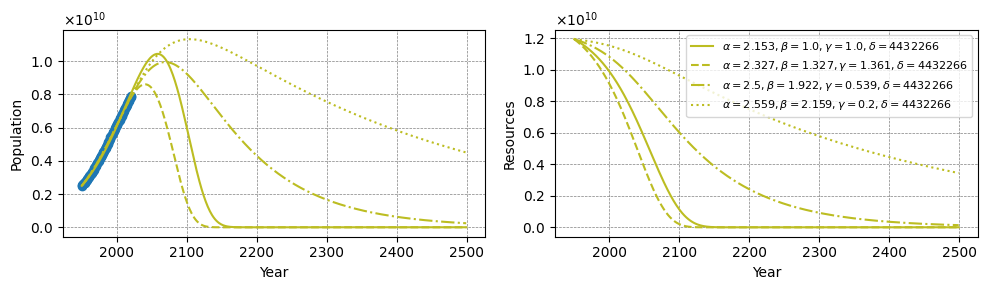

In [18]:
'''
Different predictions to the year 2500 based on fitting 1950 - 2021
'''
dates_f = 2500
nf = dates_f-dates[k7]
dates_fs = np.arange(dates[k7],dates_f,1)
tf = t7[-1]+np.cumsum(np.ones(nf)*dt)
df = popn[0]

bds = [((P_08,P_08),(R_08,R_08),(10**(-2),10**1),(1,1),(1,1),(d8,d8)),
 ((P_08,P_08),(R_08,R_08),(10**(-2),10**1),(10**(-2),10**1),(10**(-2),10**1),(d8,d8)),
 ((P_08,P_08),(R_08,R_08),(2.5,10**1),(10**(-2),10**1),(10**(-2),10**1),(d8,d8)),
 ((P_08,P_08),(R_08,R_08),(10**(-2),10**1),(10**(-2),10**1),(10**(-2),2*10**-1),(d8,d8))]

preds = []

fig, ax = plt.subplots(1,2,figsize=(10,3)) 

ax[0].plot(dates[k7:],popn[k7:],'o', label = 'Data')

styles = ['-','--','-.',':']
for i in range(len(bds)):
    params_pred8 = pop_param_fit(params80, bds[i],P_data8,t8)
    a8p = params_pred8[2]
    b8p = params_pred8[3]
    c8p = params_pred8[4]
    sol_f1 = odeint(pop_res_eqns, [P_08, R_08], tf, args=(a8p, b8p, c8p, d8))
    Pf1, Rf1 = sol_f1[:, 0], sol_f1[:, 1]

    ax[0].plot(dates_fs,Pf1, 
               label = r'$\alpha = {}, \beta = {}, \gamma ={},\delta={}$'.format(np.round(a8p,3),np.round(b8p,3),np.round(c8p,3),d8),  
               color = 'tab:olive',linestyle=styles[i])
    
    
    ax[1].plot(dates_fs,Rf1,
               label = r'$\alpha = {}, \beta = {}, \gamma ={},\delta={}$'.format(np.round(a8p,3),np.round(b8p,3),np.round(c8p,3),d8),
               color = 'tab:olive',linestyle=styles[i])


leg=1
leg0=0
font_sizes = [10,10,10,10,8]
labels1=['Year','Population',font_sizes,leg0]
labels2=['Year','Resources',font_sizes,leg]
plotting(ax[0],*labels1).add_labels()
plotting(ax[1],*labels2).add_labels()
# ax.set_yscale('log')

ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0),useMathText=True)
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0),useMathText=True)

plt.tight_layout()

# plt.savefig('./plots/world_pop_proj.png', bbox_inches='tight')